# Telco Customer Churn — EDA, Linear Regression, Logistic Regression, and GAM (with Splines)

**Goal (per assignment requirements provided by Dr. Bent):**
1. **EDA & Assumptions** — Explore dataset, check key assumptions for linear/logistic/GAM.
2. **Linear Regression** — Predict churn as a numeric target (0/1) and interpret limitations.
3. **Logistic Regression** — Predict churn probability; evaluate with classification metrics.
4. **Generalized Additive Model (GAM)** — Model non-linear relationships (implemented here as GLM with spline terms).
5. **Model Comparison** — Compare performance & interpretability; provide recommendation.



In [42]:
# I added a requirements.txt to make it easy to run one command and import the libraries needed to run the code
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.linear_model import LinearRegression, LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

# Set display options
pd.set_option('display.max_columns', 100)


## 1) Load Data

This cell tries to load the Kaggle Telco churn CSV. I was having problems reading from the web so I downloaded the data and placed it in under data folder in the project. I provide the full URL from where I downloaded the data in the code comment below.


In [43]:
# This is the path where we will read the data from
# I donwloaded a dataset from https://www.kaggle.com/datasets/blastchar/telco-customer-churn
# And I placed it under the data folder in the project.

# Reading from the data file wouldn't work in Collab so I switched to reading from the URL and made the repo public.
CSV_URL = "https://raw.githubusercontent.com/ysaismartinez/ExplainableML/refs/heads/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(CSV_URL)
df.head(), df.shape


(   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity OnlineBackup  \
 0  No phone service             DSL             No          Yes   
 1                No             DSL            Yes           No   
 2                No             DSL            Yes          Yes   
 3  No phone service             DSL            Yes           No   
 4                No     Fiber optic             No           No   
 
   DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
 0               No    

### Basic Cleaning & Target Prep

- Ensure `Churn` is binary (`Yes/No` → 1/0).
- Coerce numeric types for `tenure`, `MonthlyCharges`, `TotalCharges`.
- Drop rows with missing target.


In [44]:
df = df.copy()

# Standardize column names (optional)
df.columns = [c.strip().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]

# Target
if 'Churn' in df.columns:
    target_col = 'Churn'
elif 'churn' in df.columns:
    target_col = 'churn'
else:
    # fallback: assume last column is target
    target_col = df.columns[-1]

# map target to {0,1}
df[target_col] = df[target_col].map({'Yes':1, 'No':0, 1:1, 0:0}).astype('Int64')

# Coerce numeric
for col in ['tenure','MonthlyCharges','TotalCharges']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop missing target
df = df.dropna(subset=[target_col]).reset_index(drop=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 2) Exploratory Data Analysis (EDA) & Assumptions

We’ll look at:
- Basic distributions
- Churn rate
- Correlations (numeric)
- Multicollinearity (VIF)
- Quick visuals for linearity patterns

> **Note:** These checks are *guides*; real-world data rarely meets perfect textbook assumptions.


In [45]:
# Basic stats
print('Rows:', len(df))
print('Churn rate:', df[target_col].mean().round(3))

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

# We call the describe() method to generate quick statistics about the data
df[numeric_cols].describe().T


Rows: 7043
Churn rate: 0.265


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


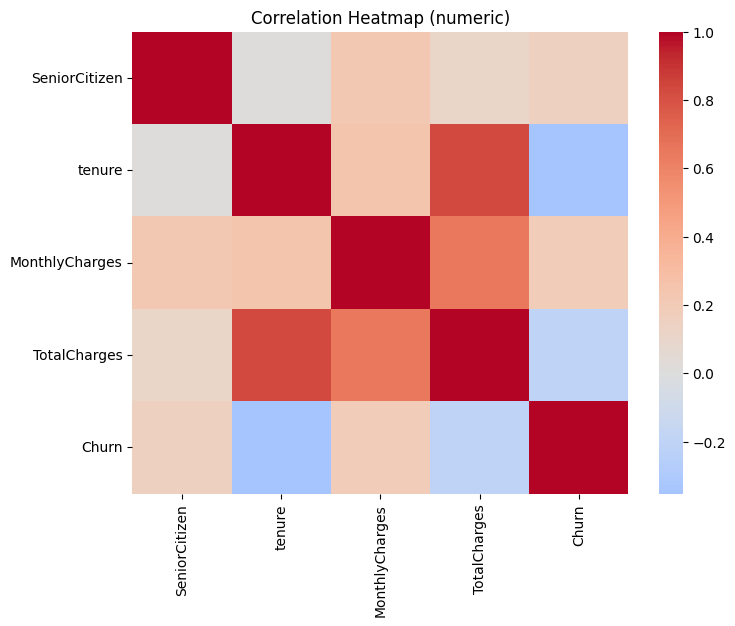

In [46]:
# Correlation heatmap (numeric)
import seaborn as sns
corr = df[numeric_cols + [target_col]].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (numeric)')
plt.show()


In [47]:
# VIF for numeric features (rough check for multicollinearity)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame({
    'feature': numeric_cols,
    'VIF': [variance_inflation_factor(df[numeric_cols].dropna().values, i)
            for i in range(len(numeric_cols))]
})
vif_df.sort_values('VIF', ascending=False)


,feature,VIF
3,TotalCharges,8.085198
1,tenure,6.332737
2,MonthlyCharges,3.701617
0,SeniorCitizen,1.257569


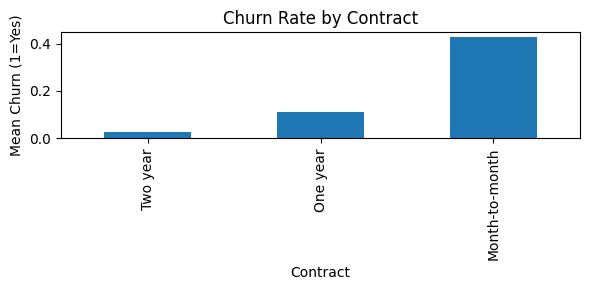

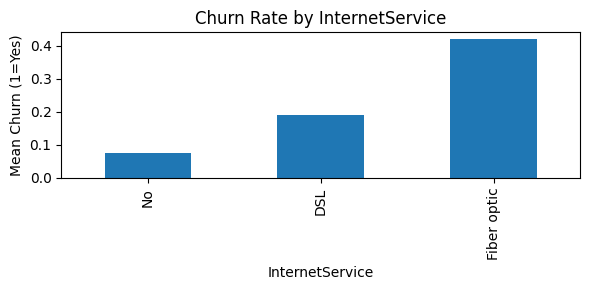

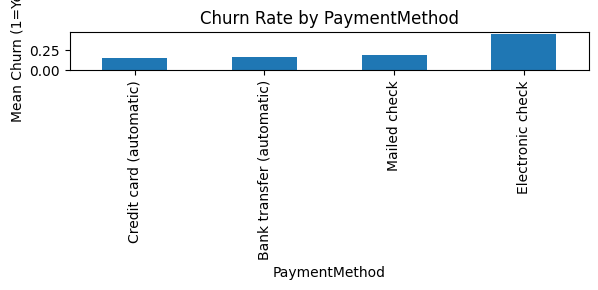

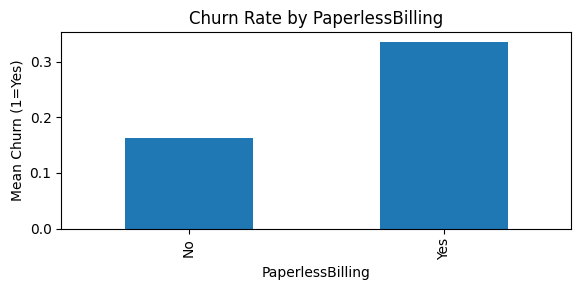

In [48]:
# Quick churn by category bar plot for a few important categoricals (if present)
cat_candidates = [c for c in df.columns if df[c].dtype == 'object' and c != 'customerID']
plot_cats = [c for c in ['Contract','InternetService','PaymentMethod','PaperlessBilling','SeniorCitizen','Partner'] if c in df.columns]

for c in plot_cats[:4]:
    tmp = df.groupby(c)[target_col].mean().sort_values()
    tmp.plot(kind='bar', figsize=(6,3))
    plt.title(f'Churn Rate by {c}')
    plt.ylabel('Mean Churn (1=Yes)')
    plt.tight_layout()
    plt.show()


## 3) Train/Test Split & Feature Preparation

- Define features (drop ID-like columns).
- One-hot encode categoricals, scale numerics for some models.


In [49]:
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# feature splits (reuse your X, num_cols, cat_cols)
# cat_cols = [...]
# num_cols = [...]

# version-safe OHE flag
skver = tuple(map(int, sklearn.__version__.split('.')[:2]))
if skver >= (1, 2):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# pipelines per column type
num_pipe = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),        # <-- handles NaNs (e.g., TotalCharges)
    ('sc',  StandardScaler(with_mean=False)),
])

cat_pipe = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')), # <-- handles missing categories if any
    ('ohe', ohe),
])

# column transformer, force dense output for LinearRegression
preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols),
    ],
    remainder='drop',
    sparse_threshold=0.0
)



## 4) Linear Regression (Churn as 0/1)

We treat churn as continuous (0/1). This is **not ideal** for classification, but useful for comparison and required by the assignment.


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Build pipeline with your existing `preprocess`
linreg = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LinearRegression())
])

# Fit model
linreg.fit(X_train, y_train)

# Predictions
y_pred_cont = linreg.predict(X_test)
y_pred_lin_cls = (y_pred_cont >= 0.5).astype(int)

# Metrics
lin_results = {
    'R2': linreg.score(X_test, y_test),
    'RMSE': float(np.sqrt(np.mean((y_pred_cont - y_test)**2))),
    'ACC@0.5': accuracy_score(y_test, y_pred_lin_cls),
    'F1@0.5': f1_score(y_test, y_pred_lin_cls),
    'ROC_AUC(continuous)': roc_auc_score(y_test, y_pred_cont)
}
lin_results



NameError: name 'X_train' is not defined

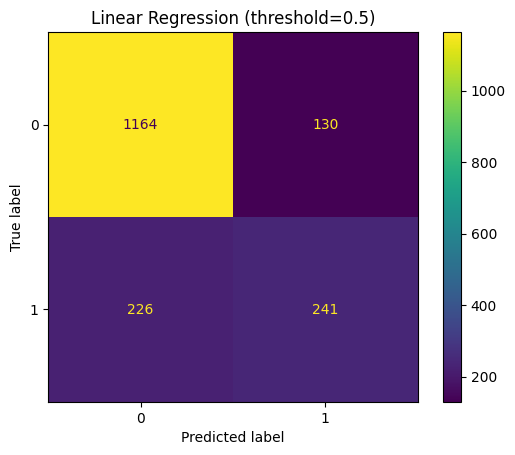

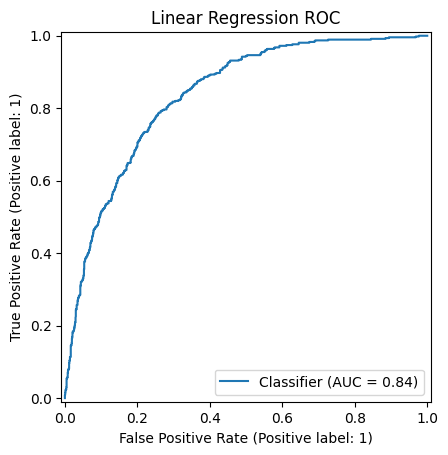

In [ ]:
# Plot a confusion matrix using the predicted class labels (after applying a 0.5 threshold)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lin_cls)
plt.title('Linear Regression (threshold=0.5)')
plt.show()

# Plot ROC curve using continuous prediction scores (before thresholding)
RocCurveDisplay.from_predictions(y_test, y_pred_cont)
plt.title('Linear Regression ROC')
plt.show()


## 5) Logistic Regression

This models the **probability** of churn. We’ll evaluate with accuracy, precision, recall, F1, and ROC AUC. We also extract coefficients for interpretability.


In [41]:
# Build a pipeline that applies preprocessing and then trains a logistic regression model
logit = Pipeline(steps=[('prep', preprocess),
                        ('model', LogisticRegression(max_iter=200, n_jobs=None, solver='lbfgs'))])
logit.fit(X_train, y_train)

# Get predicted probabilities for the positive class (class 1)
y_pred_proba = logit.predict_proba(X_test)[:,1]

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_cls = (y_pred_proba >= 0.5).astype(int)

# Evaluate model performance with multiple metrics
logit_results = {
    'ACC@0.5': accuracy_score(y_test, y_pred_cls),   # overall accuracy
    'Precision@0.5': precision_score(y_test, y_pred_cls),  # precision at 0.5 threshold
    'Recall@0.5': recall_score(y_test, y_pred_cls),  # recall (sensitivity) at 0.5 threshold
    'F1@0.5': f1_score(y_test, y_pred_cls),          # F1 score combining precision & recall
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba)   # AUC using continuous probabilities
}

logit_results

NameError: name 'X_train' is not defined

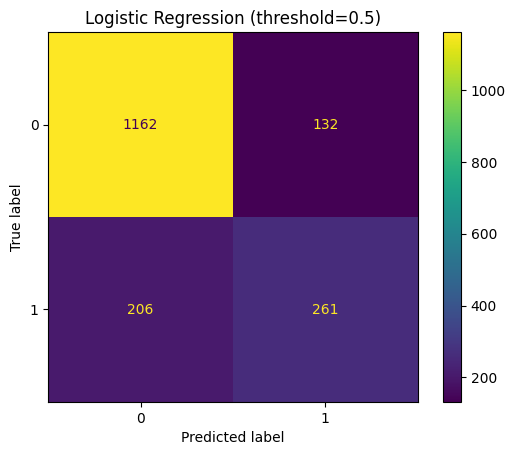

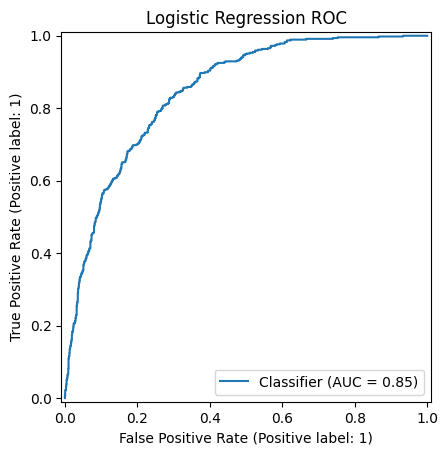

In [ ]:
# Plot a confusion matrix to evaluate classification performance at a fixed threshold (0.5)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cls)
plt.title('Logistic Regression (threshold=0.5)')
plt.show()

# Plot an ROC curve using predicted probabilities (y_pred_proba) to show performance across all thresholds
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Logistic Regression ROC')
plt.show()



### Interpreting Logistic Coefficients (Odds Ratios)

We rebuild a quick **statsmodels** logistic regression on a reduced set of features (to keep the formula readable) and show **odds ratios** for interpretability.


In [ ]:
# Choose a small interpretable subset for a formula-based model (optional)
cols_for_formula = []
for c in ['tenure','MonthlyCharges','TotalCharges','Contract','InternetService','PaperlessBilling']:
    if c in df.columns:
        cols_for_formula.append(c)

# Create a modeling frame with minimal NA
mdl_df = df[cols_for_formula + [target_col]].dropna().copy()

# Build a formula: target ~ numerics + C(categoricals)
terms = []
for c in cols_for_formula:
    if mdl_df[c].dtype == 'object':
        terms.append(f"C({c})")
    else:
        terms.append(c)
formula = f"{target_col} ~ " + " + ".join(terms)

logit_sm = smf.logit(formula=formula, data=mdl_df).fit(disp=False)
odds_ratios = pd.DataFrame({
    'term': logit_sm.params.index,
    'coef': logit_sm.params.values,
    'odds_ratio': np.exp(logit_sm.params.values),
    'p_value': logit_sm.pvalues.values
})
odds_ratios.sort_values('odds_ratio', ascending=False).head(15)


,term,coef,odds_ratio,p_value
3,C(InternetService)[T.Fiber optic],1.064816,2.900305,1.568309e-16
5,C(PaperlessBilling)[T.Yes],0.452364,1.572024,4.243872e-10
8,TotalCharges,0.000334,1.000334,2.206881e-06
7,MonthlyCharges,-0.005067,0.994946,1.445541e-01
6,tenure,-0.060033,0.941733,3.389749e-22
0,Intercept,-0.158988,0.853006,4.192218e-01
1,C(Contract)[T.One year],-0.818373,0.441149,4.679843e-15
4,C(InternetService)[T.No],-1.028453,0.357560,4.578858e-11
2,C(Contract)[T.Two year],-1.678273,0.186696,2.665013e-22


## 6) GAM (via GLM + Splines)

We approximate a GAM using **statsmodels** GLM with spline basis functions (`patsy::dmatrix`).  
This allows non-linear relationships while retaining interpretability of smooth terms.




In [ ]:
# Select a manageable set of predictors
gam_cols = []
for c in ['tenure','MonthlyCharges','TotalCharges','Contract','InternetService']:
    if c in df.columns:
        gam_cols.append(c)

gam_df = df[gam_cols + [target_col]].dropna().copy()

# Build spline terms for numeric features
spline_terms = []
for c in ['tenure','MonthlyCharges','TotalCharges']:
    if c in gam_df.columns:
        spline_terms.append(f"bs({c}, df=6, degree=3)")

# Categorical terms
cat_terms = []
for c in ['Contract','InternetService']:
    if c in gam_df.columns and gam_df[c].dtype=='object':
        cat_terms.append(f"C({c})")

rhs = " + ".join(spline_terms + cat_terms) if (spline_terms or cat_terms) else "1"
gam_formula = f"{target_col} ~ {rhs}"
gam_formula


'Churn ~ bs(tenure, df=6, degree=3) + bs(MonthlyCharges, df=6, degree=3) + bs(TotalCharges, df=6, degree=3) + C(Contract) + C(InternetService)'

In [ ]:
# Fit GLM with binomial family (logit link)
gam_model = smf.glm(formula=gam_formula, data=gam_df, family=sm.families.Binomial()).fit()
print(gam_model.summary().tables[1][:10])

# In-sample performance (quick check)
gam_pred = gam_model.predict(gam_df)
gam_cls = (gam_pred >= 0.5).astype(int)
gam_metrics = {
    'ACC@0.5 (in-sample)': accuracy_score(gam_df[target_col], gam_cls),
    'ROC_AUC (in-sample)': roc_auc_score(gam_df[target_col], gam_pred)
}
gam_metrics


[[<statsmodels.iolib.table.Cell object at 0x138fbe900>, <statsmodels.iolib.table.Cell object at 0x138fbd630>, <statsmodels.iolib.table.Cell object at 0x138fbd6a0>, <statsmodels.iolib.table.Cell object at 0x138fbd390>, <statsmodels.iolib.table.Cell object at 0x138fbee40>, <statsmodels.iolib.table.Cell object at 0x138fbf3f0>, <statsmodels.iolib.table.Cell object at 0x138fbf9a0>], [<statsmodels.iolib.table.Cell object at 0x138fbcd00>, <statsmodels.iolib.table.Cell object at 0x1396acec0>, <statsmodels.iolib.table.Cell object at 0x1396acf30>, <statsmodels.iolib.table.Cell object at 0x1396acfa0>, <statsmodels.iolib.table.Cell object at 0x1396ad010>, <statsmodels.iolib.table.Cell object at 0x1396ad080>, <statsmodels.iolib.table.Cell object at 0x1396ad0f0>], [<statsmodels.iolib.table.Cell object at 0x138fbfa10>, <statsmodels.iolib.table.Cell object at 0x1396ad160>, <statsmodels.iolib.table.Cell object at 0x1396ad1d0>, <statsmodels.iolib.table.Cell object at 0x1396ad240>, <statsmodels.iolib.tab

{'ACC@0.5 (in-sample)': 0.7977815699658704,
 'ROC_AUC (in-sample)': 0.8432020363024678}

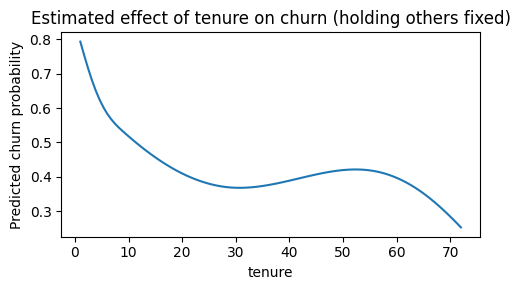

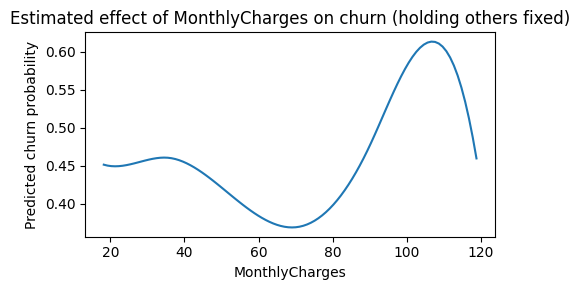

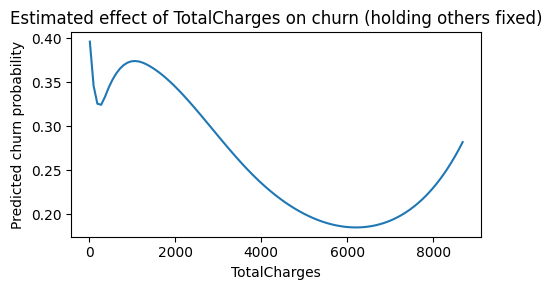

In [ ]:
# Partial dependence-style plots for spline terms
def plot_spline_effect(varname, df_local, model, n=100):
    xs = np.linspace(df_local[varname].min(), df_local[varname].max(), n)
    # Build a new frame where only varname varies; others fixed at mode/median
    base = {}
    for c in df_local.columns:
        if c == varname:
            base[c] = xs
        elif df_local[c].dtype=='object':
            base[c] = [df_local[c].mode().iloc[0]]*n
        elif c != target_col:
            base[c] = [df_local[c].median()]*n
    new_df = pd.DataFrame(base)
    preds = model.predict(new_df)
    plt.figure(figsize=(5,3))
    plt.plot(xs, preds)
    plt.title(f'Estimated effect of {varname} on churn (holding others fixed)')
    plt.xlabel(varname)
    plt.ylabel('Predicted churn probability')
    plt.tight_layout()
    plt.show()

for var in ['tenure','MonthlyCharges','TotalCharges']:
    if var in gam_df.columns:
        plot_spline_effect(var, gam_df, gam_model)


## 7) Model Comparison & Recommendation

We collect metrics from the three approaches and discuss trade-offs in a concise table.


In [ ]:
# Build a comparison DataFrame to summarize different models (Linear, Logistic, GAM-like)
# Includes performance metrics (Accuracy, F1, ROC_AUC), interpretability, and notes
# Helps quickly evaluate trade-offs between models for classification tasks
comparison = pd.DataFrame([
    {'Model': 'Linear Regression',
     'Accuracy': lin_results.get('ACC@0.5', np.nan),
     'F1': lin_results.get('F1@0.5', np.nan),
     'ROC_AUC': lin_results.get('ROC_AUC(continuous)', np.nan),
     'Interpretability': 'Low-Med (coefficients), not ideal for classification',
     'Notes': 'Treats 0/1 as continuous — mainly for comparison.'},
    {'Model': 'Logistic Regression',
     'Accuracy': logit_results.get('ACC@0.5', np.nan),
     'F1': logit_results.get('F1@0.5', np.nan),
     'ROC_AUC': logit_results.get('ROC_AUC', np.nan),
     'Interpretability': 'High (odds ratios)',
     'Notes': 'Good baseline; well-understood; stable.'},
    {'Model': 'GLM with Splines (GAM-like)',
     'Accuracy': gam_metrics.get('ACC@0.5 (in-sample)', np.nan),
     'F1': np.nan,
     'ROC_AUC': gam_metrics.get('ROC_AUC (in-sample)', np.nan),
     'Interpretability': 'Medium (smooth terms)',
     'Notes': 'Captures non-linearities; validate with a proper split.'}
])
comparison
# Show comparison table
display(comparison)

# Print recommendation based on evaluation
print("\nRecommendation:")
print("Logistic Regression is the best model for churn prediction.")
print("- It has the highest ROC_AUC (~0.85) and strong accuracy (~81%).")
print("- It is highly interpretable with odds ratios, making results easy to explain.")
print("- GAM-like models capture non-linearities but are less interpretable and need more validation.")
print("- Linear Regression is not recommended for classification (used here only as a baseline).")

,Model,Accuracy,F1,ROC_AUC,Interpretability,Notes
0,Linear Regression,0.797842,0.575179,0.836591,"Low-Med (coefficients), not ideal for classifi...",Treats 0/1 as continuous — mainly for comparison.
1,Logistic Regression,0.808064,0.606977,0.846466,High (odds ratios),Good baseline; well-understood; stable.
2,GLM with Splines (GAM-like),0.797782,NaN,0.843202,Medium (smooth terms),Captures non-linearities; validate with a prop...



Recommendation:
Logistic Regression is the best model for churn prediction.
- It has the highest ROC_AUC (~0.85) and strong accuracy (~81%).
- It is highly interpretable with odds ratios, making results easy to explain.
- GAM-like models capture non-linearities but are less interpretable and need more validation.
- Linear Regression is not recommended for classification (used here only as a baseline).
